# Experiments for MDD article

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../eeg-research/')

from os.path import join

import pipeline.features
import pipeline.models

base_path = '../own_data/191104_depr_splits_features/'

/Users/ledovsky/anaconda3/lib/python3.7/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
feature_methods = [
    'env-alpha',
    'env-beta',
    'coh-alpha',
    'coh-beta',
    'bands'
]


In [5]:
def plot_curves(hist):
    pal = sns.color_palette('Set2')
    
    fig = plt.figure(figsize=[8, 4])
    l1, = plt.plot(hist.index, hist['score'], 
                   label='First timeframe, ROC-AUC = {:.2f}'.format(hist['score'].iloc[-1]),
                   color=pal[2])
    l2, = plt.plot(hist.index, hist['score_val'], 
                   label='Second (control) timeframe, ROC-AUC = {:.2f}'.format(hist['score_val'].iloc[-1]),
                   color=pal[1])
    
    lb = hist['score'] - hist['score_std'] * 1.96
    ub = hist['score'] + hist['score_std'] * 1.96
    plt.fill_between(hist.index, lb, ub, alpha=0.5, color=pal[2])
    lb = hist['score_val'] - hist['score_val_std'] * 1.96
    ub = hist['score_val'] + hist['score_val_std'] * 1.96
    plt.fill_between(hist.index, lb, ub, alpha=0.5, color=pal[1])
    plt.xlabel('Feature selection step')
    plt.ylabel('ROC-AUC')
    plt.ylim([0.5, 1.0])
    plt.legend(loc=0)
    return fig

In [6]:
def plot_roc_curve(y_true, y_pred, title=None, auc=None, save_path=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    if auc is None:
        auc = roc_auc_score(y_true, y_pred)
        
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (average area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title is not None:
        plt.title(title)
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path, transparent=True, dpi=150)

## Experiment 1 - not in the notebook, only final model

In [10]:
dir_ = '60s_1_0_60'
df_60_all_feats = pipeline.features.get_merged_df(join(base_path, dir_), feature_methods)
df_60_env_alpha = pipeline.features.get_merged_df(join(base_path, dir_), ['env-alpha'])
df_60_coh_alpha = pipeline.features.get_merged_df(join(base_path, dir_), ['coh-alpha'])
df_60_coh_alpha_2 = pd.read_csv(join(base_path, dir_, 'coh_alpha.csv'))

In [11]:
model = pipeline.models.LRScaled()

In [12]:
features = [col for col in df_60_all_feats.columns if col not in ['fn', 'target']]
features_selected, best_score, hist = pipeline.models.select_features(df_60_all_feats, features, model, n_repeats=20, threshold=0.005)
res_all_feats = pipeline.models.kfold(df_60_all_feats[features_selected].fillna(0).values, df_60_all_feats['target'], model)


Feature selection. Step 1


Feature selection. Step 2


In [13]:
features = [col for col in df_60_env_alpha.columns if col not in ['fn', 'target']]
features_selected, best_score, hist = pipeline.models.select_features(df_60_env_alpha, features, model, n_repeats=20, threshold=0.01)
res_env_alpha = pipeline.models.kfold(df_60_env_alpha[features_selected].fillna(0).values, df_60_env_alpha['target'], model)


Feature selection. Step 1


Feature selection. Step 2


In [14]:
features = [col for col in df_60_coh_alpha.columns if col not in ['fn', 'target']]
features_selected, best_score, hist = pipeline.models.select_features(df_60_coh_alpha, features, model, n_repeats=20, threshold=0.01)
res_coh_alpha = pipeline.models.kfold(df_60_coh_alpha[features_selected].fillna(0).values, df_60_coh_alpha['target'], model)

Feature selection. Step 1


Feature selection. Step 2


In [15]:
pal = sns.color_palette('Set2')

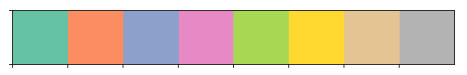

In [16]:
sns.palplot(pal)

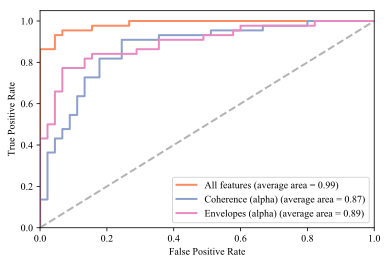

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

pal = sns.color_palette('Set2')

    
plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], color=pal[-1], lw=lw, linestyle='--')


y_true = res_all_feats.y_true
y_pred = res_all_feats.y_pred
auc=0.99
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, color=pal[1],
         lw=lw, label='All features (average area = %0.2f)' % auc)


y_true = res_coh_alpha.y_true
y_pred = res_coh_alpha.y_pred
auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, color=pal[2],
         lw=lw, label='Coherence (alpha) (average area = %0.2f)' % auc)

y_true = res_env_alpha.y_true
y_pred = res_env_alpha.y_pred
auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)   
plt.plot(fpr, tpr, color=pal[3],
         lw=lw, label='Envelopes (alpha) (average area = %0.2f)' % auc)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

    
plt.legend(loc="lower right")

# plt.savefig('roc_aucs.png', transparent=True, dpi=200)

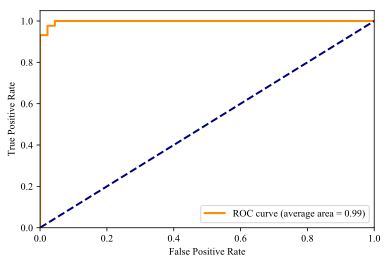

In [43]:
plot_roc_curve(
    res.y_true, 
    res.y_pred, 
    auc=0.99, 
    title=None, 
    save_path='roc_curve_final_model.png')

## Experiment 2 - validation on different timeframes

In [49]:
dir_1 = '30s_1_0_30'
dir_2 = '30s_1_30_60'
dir_3 = '30s_0_30_60'
dir_4 = '30s_0_0_30'

df = pipeline.features.get_merged_df(join(base_path, dir_2), feature_methods)
df_val = pipeline.features.get_merged_df(join(base_path, dir_1), feature_methods)
df_val_2 = pipeline.features.get_merged_df(join(base_path, dir_3), feature_methods)
df_val_3 = pipeline.features.get_merged_df(join(base_path, dir_4), feature_methods)

In [53]:
features = [col for col in df.columns if col not in ['fn', 'target']]
model = pipeline.models.LRScaled()

In [7]:
features_selected, best_score, hist = pipeline.models.select_features(df, features, model, df_val=df_val_2, n_repeats=20, threshold=0.001)
hist

Feature selection. Step 1



Feature selection. Step 2


,feature,action,score,score_val
0,bands_gamma_fz,added,0.576162,0.601566
1,coh_beta_f3_f4,added,0.656591,0.639495
2,bands_gamma_p3,added,0.677374,0.642475
3,coh_beta_fp1_fz,added,0.750530,0.718763
4,coh_alpha_fp1_fz,added,0.751818,0.718636
5,coh_alpha_t6_c3,added,0.827475,0.757424
6,coh_beta_o1_t5,added,0.848333,0.788409
7,env_alpha_p4_c4,added,0.864369,0.812778
8,coh_alpha_t6_fp1,added,0.886364,0.814167
9,coh_beta_f7_fz,added,0.901894,0.804470


In [261]:
features_selected, best_score, hist = pipeline.models.select_features(df, features, model, df_val=df_val_3, n_repeats=20, threshold=0.001)
hist

Feature selection. Step 1


Feature selection. Step 2


In [250]:
features_selected, best_score, hist = pipeline.models.select_features(df, features, model, df_val=df_val, n_repeats=20, threshold=0.002)
hist

Feature selection. Step 1


Feature selection. Step 2


In [54]:
features_selected, best_score, hist = pipeline.models.select_features(df, features, model, df_val=df_val, n_repeats=20, threshold=0.01)
hist

Feature selection. Step 1



Feature selection. Step 2


,feature,action,score,score_std,score_val,score_val_std
0,bands_gamma_fz,added,0.576162,0.018470,0.557702,0.024703
1,coh_beta_f3_f4,added,0.656591,0.010999,0.632424,0.014237
2,bands_gamma_p3,added,0.677374,0.009057,0.641490,0.015013
3,coh_beta_fp1_fz,added,0.750530,0.009407,0.750379,0.010149
4,coh_alpha_t6_c3,added,0.833359,0.009433,0.771818,0.013075
5,coh_beta_o1_t5,added,0.852929,0.010679,0.809924,0.012479
6,env_alpha_p4_c4,added,0.871793,0.010805,0.815783,0.010923
7,coh_alpha_t6_fp1,added,0.891818,0.010553,0.826591,0.010636
8,coh_beta_f7_fz,added,0.905480,0.010203,0.852045,0.013324
9,env_alpha_p4_p3,added,0.927475,0.007994,0.841995,0.014689


In [55]:
hist_1 = hist.copy()
features_1 = features_selected.copy()

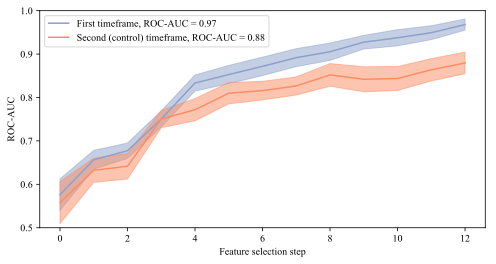

In [95]:
fig = plot_curves(hist_1);

In [96]:
fig.savefig('different_timeframes_1.png', dpi=200, bbox_inches='tight', transparent=True)

In [22]:
features_selected, best_score, hist = pipeline.models.select_features(df, features, model, df_val=df_val, n_repeats=20, threshold=0.02)
hist

  0%|          | 1/760 [00:00<01:41,  7.48it/s]

Feature selection. Step 1


 11%|█         | 1/9 [00:00<00:01,  7.01it/s]

Feature selection. Step 2


100%|██████████| 9/9 [00:01<00:00,  6.78it/s]


,action,feature,score,score_val
0,added,bands_gamma_fz,0.576162,0.557702
1,added,coh_beta_f3_f4,0.656591,0.632424
2,added,bands_gamma_p3,0.677374,0.641490
3,added,coh_beta_fp1_fz,0.750530,0.750379
4,added,coh_alpha_t6_c3,0.833359,0.771818
5,added,coh_beta_f7_fz,0.865884,0.783636
6,added,env_beta_p4_c4,0.892020,0.805859
7,added,env_alpha_t6_fp1,0.939470,0.805556
8,added,coh_beta_f8_o2,0.959722,0.817475


In [23]:
features_selected, best_score, hist = pipeline.models.select_features(df, features, model, df_val=df_val, n_repeats=20, threshold=0.03)
hist

  0%|          | 1/760 [00:00<01:44,  7.27it/s]

Feature selection. Step 1


 14%|█▍        | 1/7 [00:00<00:00,  7.01it/s]

Feature selection. Step 2


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


,action,feature,score,score_val
0,added,bands_gamma_fz,0.576162,0.557702
1,added,coh_beta_f3_f4,0.656591,0.632424
2,added,coh_beta_fp1_fz,0.746111,0.747247
3,added,coh_alpha_t6_c3,0.834040,0.775606
4,added,coh_beta_f7_fz,0.868788,0.789823
5,added,coh_beta_p4_c4,0.901465,0.837904
6,added,env_alpha_t6_fp1,0.948258,0.832323


In [243]:
features_selected, best_score, hist = pipeline.models.select_features(df_val, features, model, df_val=df, n_repeats=20, threshold=0.03)
hist

Feature selection. Step 1


Feature selection. Step 2


,action,feature,score,score_val
0,added,coh_beta_fp1_fz,0.540581,0.489823
1,added,coh_beta_o1_t5,0.592551,0.538611
2,added,coh_alpha_f3_f4,0.738005,0.692727
3,added,env_alpha_c4_f4,0.784318,0.725126
4,added,bands_gamma_fp1,0.824646,0.801717
5,added,coh_beta_f3_pz,0.860985,0.812121
6,added,env_beta_t4_f4,0.891919,0.825152


In [244]:
features_selected, best_score, hist = pipeline.models.select_features(df, features, model, df_val=df_val_2, n_repeats=20, threshold=0.03)
hist

Feature selection. Step 1


Feature selection. Step 2


,action,feature,score,score_val
0,added,bands_gamma_fz,0.576162,0.601566
1,added,coh_beta_f3_f4,0.656591,0.639495
2,added,coh_beta_fp1_fz,0.746111,0.703232
3,added,coh_alpha_t6_c3,0.834040,0.756338
4,added,coh_beta_f7_fz,0.868788,0.743611
5,added,coh_beta_p4_c4,0.901465,0.747879
6,added,env_alpha_t6_fp1,0.948258,0.798081


In [245]:
features_selected, best_score, hist = pipeline.models.select_features(df_val_2, features, model, df_val=df, n_repeats=20, threshold=0.03)
hist

Feature selection. Step 1


Feature selection. Step 2


,action,feature,score,score_val
0,added,coh_beta_o1_t5,0.588081,0.557424
1,added,env_alpha_t6_f3,0.731894,0.734672
2,added,env_alpha_p4_c4,0.790429,0.769217
3,added,bands_gamma_t6,0.833485,0.816263
4,added,coh_alpha_o1_c4,0.870859,0.804394


In [18]:
features_selected, best_score, hist = pipeline.models.select_features(df, features, model, df_val=df_val, n_repeats=20, threshold=0.04, take_first=100)

Feature selection. Step 1



Feature selection. Step 2


In [19]:
hist

,action,feature,score,score_val
0,added,bands_gamma_fz,0.576162,0.557702
1,added,coh_beta_f3_f4,0.656591,0.632424
2,added,coh_beta_fp1_fz,0.746111,0.747247
3,added,coh_alpha_t6_c3,0.834040,0.775606
4,added,env_alpha_t6_fp1,0.896793,0.773131


In [21]:
hist

Feature selection. Step 1



Feature selection. Step 2


,action,feature,score,score_val
0,added,bands_gamma_fz,0.576162,0.601566
1,added,coh_beta_f3_f4,0.656591,0.639495
2,added,bands_gamma_p3,0.677374,0.642475
3,added,coh_beta_fp1_fz,0.750530,0.718763
4,added,coh_alpha_t6_c3,0.833359,0.763106
5,added,coh_beta_o1_t5,0.852929,0.792652
6,added,env_alpha_p4_c4,0.871793,0.818409
7,added,coh_alpha_t6_fp1,0.891818,0.821515
8,added,coh_beta_f7_fz,0.905480,0.811212
9,added,env_alpha_p4_p3,0.927475,0.806237


## Experiment 3 - Intrasubject stability

In [15]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

In [16]:
X, y = pipeline.models.get_x_y(df, features)
model.fit(X, y)
X, y = pipeline.models.get_x_y(df_val, features)
y_pred = model.predict_proba(X)[:, 1]

In [17]:
roc_auc_score(y, y_pred)

0.9287878787878787

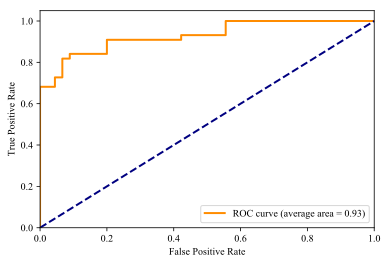

In [27]:
plot_roc_curve(
    y, 
    y_pred, 
#     auc=0.76, 
    title=None, 
    save_path='roc_curve_intrasample.png')

In [21]:
confusion_matrix(y, y_pred > 0.5)

array([[38,  7],
       [ 7, 37]])

## Experiment 4 - Dependency from sample size

In [98]:
# dir_1 = '60s_1_0_60'
# df = pipeline.features.get_merged_df(join(base_path, dir_2), feature_methods)
X, y = pipeline.models.get_x_y(df_val, features_1 )

In [99]:
from tqdm import tqdm_notebook

In [100]:
rows = []
n_total = X.shape[0]


for n in tqdm_notebook(range(30, n_total)):
    for iter_idx in range(20):
        random_state = np.random.choice(np.arange(10000))
        idx = np.random.choice(np.arange(89), size=n, replace=False)
        X_cur = X[idx]
        y_cur = y[idx]
        res = pipeline.models.repeated_kfold(X_cur, y_cur, model, n_splits=10, n_repeats=20, random_state=random_state)
        d = {
            'n': n,
            'iter_idx': iter_idx,
            'roc_auc': res.roc_aucs.mean(),
            'acc': res.accs.mean()
        }
        rows.append(d)



In [101]:
res_df_stage = pd.DataFrame(rows)

res_df_stage_21 = res_df_stage.groupby(
    'n')['roc_auc', 'acc'].mean(
).rename(
    columns={
        'roc_auc': 'roc_auc_mean',
        'acc': 'acc_mean',
})

res_df_stage_22 = res_df_stage.groupby(
    'n')['roc_auc', 'acc'].std(
).rename(
    columns={
        'roc_auc': 'roc_auc_std',
        'acc': 'acc_std',
})


df_sample_size_dep = pd.concat([res_df_stage_21, res_df_stage_22], axis=1)
df_sample_size_dep.reset_index(inplace=True)

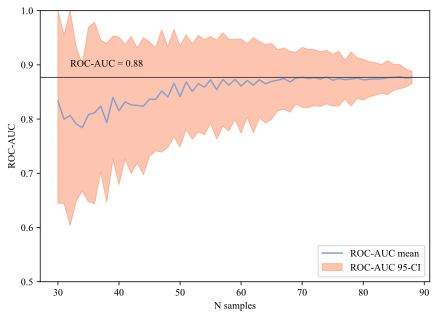

In [109]:
pal = sns.color_palette('Set2')

plt.figure(figsize=[7, 5])
# pal = sns.color_palette('deep')

plt.plot(df_sample_size_dep['n'], df_sample_size_dep['roc_auc_mean'], label='ROC-AUC mean', color=pal[2])

lb = df_sample_size_dep['roc_auc_mean'] - 1.96 * df_sample_size_dep['roc_auc_std'] 
ub = df_sample_size_dep['roc_auc_mean'] + 1.96 * df_sample_size_dep['roc_auc_std'] 
ub = np.where(ub > 1, 1, ub)
plt.fill_between(df_sample_size_dep['n'], lb, ub, color=pal[1], alpha=0.5, label='ROC-AUC 95-CI')

max_val = df_sample_size_dep.iloc[-1]['roc_auc_mean']

plt.axhline(y=max_val, xmin=0, xmax=len(df_sample_size_dep), linewidth=1, color='0.3')
plt.text(32, max_val + 0.02, 'ROC-AUC = {:.2f}'.format(max_val))

plt.legend(loc=4)
# plt.xlim([1, len(features_filtered)])
plt.xlabel('N samples')
plt.ylabel('ROC-AUC')
plt.ylim([0.5, 1])
# plt.title('ROC-AUC dependence on N samples')

plt.savefig('roc_auc_vs_n_samples.png', transparent=True, dpi=200)